### Pre-requisites

Install gensim using the following command

```pip install gensim```

Install or update NLTK module

```
pip install --user -U nltk
pip install --upgrade nltk
```

### Overview

***Reuters Corpus***

The Reuters Corpus contains 10,788 news documents totaling 1.3 million words. The documents have been classified into 90 topics, and grouped into two sets, called "training" and "test";

### Resources

- https://www.nltk.org/install.html
- https://www.nltk.org/data.html
- https://www.nltk.org/book/ch02.html

In [7]:
# Import libraries

import sys
assert sys.version_info[0] == 3
assert sys.version_info[1] >= 5
print(sys.version_info)

from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

# Download Reuters corpus from NLTK data distribution
import nltk
nltk.download('reuters')
from nltk.corpus import reuters

import numpy as np
import random
import scipy as sp
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

START_TOKEN = '<START>'
END_TOKEN = '<END>'

np.random.seed(0)
random.seed(0)

sys.version_info(major=3, minor=7, micro=3, releaselevel='final', serial=0)


[nltk_data] Downloading package reuters to /home/agoel/nltk_data...
[nltk_data]   Package reuters is already up-to-date!


### Exploring Reuters corpus

Unlike the Brown Corpus, categories in the Reuters corpus overlap with each other, simply because a news story often covers multiple topics. We can ask for the topics covered by one or more documents, or for the documents included in one or more categories. For convenience, the corpus methods accept a single fileid or a list of fileids.

In [8]:
# The text with fileid 'test/14826' is a document drawn from the test set.
print(reuters.fileids()[0:10])
# News document count
print('News documents count: {}'.format(len(reuters.fileids())))

['test/14826', 'test/14828', 'test/14829', 'test/14832', 'test/14833', 'test/14839', 'test/14840', 'test/14841', 'test/14842', 'test/14843']
News documents count: 10788


In [9]:
print('categories count: {}'.format(len(reuters.categories())), end='\n\n')
print('Categories: {}'.format(reuters.categories()[0:20]), end='\n\n')
print('Categories in the document \'training/9865\': {}'.format(reuters.categories('training/9865')), end='\n\n')
print(reuters.fileids('barley')[0:10], end='\n\n')
print('Words by document/file: {}'.format(reuters.words('training/9865')[:14]), end='\n\n')
print('Words by categories: {}'.format(reuters.words(categories='barley')), end='\n\n')
print('Words by multiple categories: {}'.format(reuters.words(categories=['barley', 'corn'])))

categories count: 90

Categories: ['acq', 'alum', 'barley', 'bop', 'carcass', 'castor-oil', 'cocoa', 'coconut', 'coconut-oil', 'coffee', 'copper', 'copra-cake', 'corn', 'cotton', 'cotton-oil', 'cpi', 'cpu', 'crude', 'dfl', 'dlr']

Categories in the document 'training/9865': ['barley', 'corn', 'grain', 'wheat']

['test/15618', 'test/15649', 'test/15676', 'test/15728', 'test/15871', 'test/15875', 'test/15952', 'test/17767', 'test/17769', 'test/18024']

Words by document/file: ['FRENCH', 'FREE', 'MARKET', 'CEREAL', 'EXPORT', 'BIDS', 'DETAILED', 'French', 'operators', 'have', 'requested', 'licences', 'to', 'export']

Words by categories: ['FRENCH', 'FREE', 'MARKET', 'CEREAL', 'EXPORT', ...]

Words by multiple categories: ['THAI', 'TRADE', 'DEFICIT', 'WIDENS', 'IN', 'FIRST', ...]


### Co-occurrence

A co-occurrence matrix counts how often things co-occur in some environment. Given some word $w_i$  occurring in the document, we consider the context window surrounding $w_i$. Supposing our fixed window size is n, then this is the n preceding and n subsequent words in that document, i.e. words  $w_{i-n}…w_{i-1}$  and  $w_{i+1}…w_{i+n}$ . We build a co-occurrence matrix M, which is a symmetric word-by-word matrix in which  $M_{ij}$  is the number of times $w_{j}$ appears inside  $w_{i}$'s window.words

***Example: Co-Occurrence with Fixed Window of n=1:***

Document 1: "all that glitters is not gold"

Document 2: "all is well that ends well"

![title](static/co_occurence_matrix.png)


The rows (or columns) of this matrix provide one type of word vectors (those based on word-word co-occurrence), but the vectors will be large in general (linear in the number of distinct words in a corpus). 

### Plotting Co-Occurrence Word Embeddings

In [10]:
def read_corpus(category='crude'):
    
    """ Read files from the specified Reuter's category.
        Params:
            category (string): category name
        Return:
            list of lists, with words from each of the processed files
    """
    
    files = reuters.fileids(category)
    return [[START_TOKEN] + [w.lower() for w in list(reuters.words(f))] + [END_TOKEN] for f in files]

In [11]:
reuters_corpus = read_corpus()
pprint.pprint(reuters_corpus[:3], compact=True, width=90)

[['<START>', 'japan', 'to', 'revise', 'long', '-', 'term', 'energy', 'demand',
  'downwards', 'the', 'ministry', 'of', 'international', 'trade', 'and', 'industry', '(',
  'miti', ')', 'will', 'revise', 'its', 'long', '-', 'term', 'energy', 'supply', '/',
  'demand', 'outlook', 'by', 'august', 'to', 'meet', 'a', 'forecast', 'downtrend', 'in',
  'japanese', 'energy', 'demand', ',', 'ministry', 'officials', 'said', '.', 'miti', 'is',
  'expected', 'to', 'lower', 'the', 'projection', 'for', 'primary', 'energy', 'supplies',
  'in', 'the', 'year', '2000', 'to', '550', 'mln', 'kilolitres', '(', 'kl', ')', 'from',
  '600', 'mln', ',', 'they', 'said', '.', 'the', 'decision', 'follows', 'the',
  'emergence', 'of', 'structural', 'changes', 'in', 'japanese', 'industry', 'following',
  'the', 'rise', 'in', 'the', 'value', 'of', 'the', 'yen', 'and', 'a', 'decline', 'in',
  'domestic', 'electric', 'power', 'demand', '.', 'miti', 'is', 'planning', 'to', 'work',
  'out', 'a', 'revised', 'energy', 'supp

### Find distinct words in a corpus

Below is a method to work out the distinct words (word types) that occur in the corpus. We can do this with for loops, but it's more efficient to do it with Python list comprehensions. In particular, please refer to [this](http://web.stanford.edu/class/cs224n/assignments/a1_preview/exploring_word_vectors.html) to flatten a list of lists. For more information on list comprehensions, please refer [here](https://coderwall.com/p/rcmaea/flatten-a-list-of-lists-in-one-line-in-python)

You may find it useful to use [Python sets](https://www.w3schools.com/python/python_sets.asp) to remove duplicate words.

In [12]:
def distinct_words(corpus):
    
    """ Determine a list of distinct words for the corpus.
        Params:
            corpus (list of list of strings): corpus of documents
        Return:
            corpus_words (list of strings): list of distinct words across the corpus, sorted (using python 'sorted' function)
            num_corpus_words (integer): number of distinct words across the corpus
    """
    corpus_words = []
    num_corpus_words = -1
    
    """List comprehensions are cleaner and faster than the for loop
       A set is a collection which is unordered, unindexed and contains unique elements. 
      In Python sets are written with curly brackets.
    """
    corpus_set = {w for s in corpus for w in s}
    sorted_corpus_set = sorted(corpus_set)
    corpus_words = sorted_corpus_set
    num_corpus_words = len(corpus_words)
    
    return corpus_words, num_corpus_words

In [13]:
# Define toy corpus
test_corpus = ["START All that glitters isn't gold END".split(" "), "START All's well that ends well END".split(" ")]
test_corpus_words, num_corpus_words = distinct_words(test_corpus)

# Correct answers
ans_test_corpus_words = sorted(list(set(["START", "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", "END"])))
ans_num_corpus_words = len(ans_test_corpus_words)

# Test correct number of words
assert(num_corpus_words == ans_num_corpus_words), "Incorrect number of distinct words. Correct: {}. Yours: {}".format(ans_num_corpus_words, num_corpus_words)

# Test correct words
assert (test_corpus_words == ans_test_corpus_words), "Incorrect corpus_words.\nCorrect: {}\nYours:   {}".format(str(ans_test_corpus_words), str(test_corpus_words))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Compute co-occurence matrix

Below is a method that constructs a co-occurrence matrix for a certain window-size n (with a default of 4), considering words n  before and n  after the word in the center of the window. Here, we will use numpy (np) to represent vectors, matrices, and tensors. If  not familiar with NumPy, there's a NumPy tutorial in the second half of this [Python NumPy tutorial](http://cs231n.github.io/python-numpy-tutorial/)

In [14]:
def compute_co_occurrence_matrix(corpus, window_size=4):
    """ Compute co-occurrence matrix for the given corpus and window_size (default of 4).
    
        Note: Each word in a document should be at the center of a window. Words near edges will have a smaller
              number of co-occurring words.
              
              For example, if we take the document "START All that glitters is not gold END" with window size of 4,
              "All" will co-occur with "START", "that", "glitters", "is", and "not".
    
        Params:
            corpus (list of list of strings): corpus of documents
            window_size (int): size of context window
        Return:
            M (numpy matrix of shape (number of corpus words, number of corpus words)): 
            Co-occurence matrix of word counts. 
            The ordering of the words in the rows/columns should be the same as the ordering of the words given by the distinct_words function.
            word2Ind (dict): dictionary that maps word to index (i.e. row/column number) for matrix M.)
    """
    
    words, num_words = distinct_words(corpus)
    M = None
    word2Ind = {}
    
    # A Matrix of zeros with shape (num_words, num_words)
    M = np.zeros((num_words, num_words))
    
    for i in range(num_words):
        word2Ind[words[i]] = i
   
    for line in corpus:
        for i in range(len(line)):
            target = line[i]
            target_idx = word2Ind[target]
            
            #print('{} - {} - {} - {}'.format(target, target_idx, len(line), i))
            
            for j in range(max(i - window_size, 0), min(i + window_size + 1, len(line))):
                if i != j and j >= i:
                    M[target_idx][word2Ind[line[j]]] += 1
                    M[word2Ind[line[j]]][target_idx] += 1
            
    return M, word2Ind

In [15]:
# Define toy corpus and get student's co-occurrence matrix
test_corpus = ["START All that glitters isn't gold END".split(" "), "START All's well that ends well END".split(" ")]
M_test, word2Ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)

# Correct M and word2Ind
M_test_ans = np.array( 
    [[0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,],
     [0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,],
     [0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,],
     [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,],
     [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,],
     [0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,],
     [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,],
     [1., 0., 0., 0., 1., 1., 0., 0., 0., 1.,],
     [0., 1., 1., 0., 1., 0., 0., 0., 1., 0.,]]
)
word2Ind_ans = {'All': 0, "All's": 1, 'END': 2, 'START': 3, 'ends': 4, 'glitters': 5, 'gold': 6, "isn't": 7, 'that': 8, 'well': 9}

# Test correct word2Ind
assert (word2Ind_ans == word2Ind_test), "Your word2Ind is incorrect:\nCorrect: {}\nYours: {}".format(word2Ind_ans, word2Ind_test)

# Test correct M shape
assert (M_test.shape == M_test_ans.shape), "M matrix has incorrect shape.\nCorrect: {}\nYours: {}".format(M_test.shape, M_test_ans.shape)

# Test correct M values
for w1 in word2Ind_ans.keys():
    idx1 = word2Ind_ans[w1]
    for w2 in word2Ind_ans.keys():
        idx2 = word2Ind_ans[w2]
        student = M_test[idx1, idx2]
        correct = M_test_ans[idx1, idx2]
        if student != correct:
            print("Correct M:")
            print(M_test_ans)
            print("Your M: ")
            print(M_test)
            raise AssertionError("Incorrect count at index ({}, {})=({}, {}) in matrix M. Yours has {} but should have {}.".format(idx1, idx2, w1, w2, student, correct)) 

print("Correct M:")
print(M_test_ans)
print("Your M: ")            
print(M_test)
      
# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

Correct M:
[[0. 0. 0. 1. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 1.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 0. 0. 0.]
 [1. 0. 0. 0. 1. 1. 0. 0. 0. 1.]
 [0. 1. 1. 0. 1. 0. 0. 0. 1. 0.]]
Your M: 
[[0. 0. 0. 1. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 1.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 0. 0. 0.]
 [1. 0. 0. 0. 1. 1. 0. 0. 0. 1.]
 [0. 1. 1. 0. 1. 0. 0. 0. 1. 0.]]
--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Reduce to K dimensions

Below method performs dimensionality reduction on the matrix to produce k-dimensional embeddings. Use Singular value decomposition(SVD) to take the top k components and produce a new matrix of k-dimensional embeddings.

***Note:*** All of numpy, scipy, and scikit-learn (sklearn) provide some implementation of SVD, but only scipy and sklearn provide an implementation of Truncated SVD, and only sklearn provides an efficient randomized algorithm for calculating large-scale Truncated SVD. So we'll use [sklearn.decomposition.TruncatedSVD.](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html)

In [16]:
def reduce_to_k_dim(M, k=2):
    """ Reduce a co-occurence count matrix of dimensionality (num_corpus_words, num_corpus_words)
        to a matrix of dimensionality (num_corpus_words, k) using the following SVD function from Scikit-Learn:
            - http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
    
        Params:
            M (numpy matrix of shape (number of corpus words, number of corpus words)): co-occurence matrix of word counts
            k (int): embedding size of each word after dimension reduction
        Return:
            M_reduced (numpy matrix of shape (number of corpus words, k)): matrix of k-dimensioal word embeddings.
                    In terms of the SVD from maths, this actually returns U * S
    """    
    
    n_iters = 10
    M_reduced = None
    
    svd = TruncatedSVD(n_components=k)
    
    # Fit Latent semantic indexing (LSI) model to X and perform dimensionality reduction on X.
    M_reduced = svd.fit_transform(M)
    
    print('Done.')
    return M_reduced

In [17]:
# ---------------------
# Run this sanity check
# Note that this not an exhaustive check for correctness 
# In fact we only check that your M_reduced has the right dimensions.
# ---------------------

# Define toy corpus and run student code
test_corpus = ["START All that glitters isn't gold END".split(" "), "START All's well that ends well END".split(" ")]
M_test, word2Ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)
M_test_reduced = reduce_to_k_dim(M_test, k=2)

# Test proper dimensions
assert (M_test_reduced.shape[0] == 10), "M_reduced has {} rows; should have {}".format(M_test_reduced.shape[0], 10)
assert (M_test_reduced.shape[1] == 2), "M_reduced has {} columns; should have {}".format(M_test_reduced.shape[1], 2)

print(M_test_reduced)

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

Done.
[[ 7.05647176e-01  4.84057274e-01]
 [ 7.05647176e-01 -4.84057274e-01]
 [ 6.54802087e-01 -7.83221122e-01]
 [ 5.20200324e-01  2.23833033e-14]
 [ 1.02780472e+00 -1.98869865e-14]
 [ 6.54802087e-01  7.83221122e-01]
 [ 3.82258491e-01  6.56224003e-01]
 [ 3.82258491e-01 -6.56224003e-01]
 [ 1.39420808e+00 -1.06179274e+00]
 [ 1.39420808e+00  1.06179274e+00]]
--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Plot Embeddings

Below is a function to plot a set of 2D vectors in 2D space. For graphs, we used Matplotlib (plt).

In [18]:
def plot_embeddings(M_reduced, word2Ind, words):
    """ Plot in a scatterplot the embeddings of the words specified in the list "words".
        NOTE: do not plot all the words listed in M_reduced / word2Ind.
        Include a label next to each point.
        
        Params:
            M_reduced (numpy matrix of shape (number of unique words in the corpus , k)): matrix of k-dimensioal word embeddings
            word2Ind (dict): dictionary that maps word to indices for matrix M
            words (list of strings): words whose embeddings we want to visualize
    """
      
    for i, w in enumerate(words):
        x = M_reduced[word2Ind[w]][0]
        y = M_reduced[word2Ind[w]][1]
        plt.scatter(x, y, marker='o', color='r')
        plt.text(x+0.001, y+0.001, w)
        
    plt.show()

--------------------------------------------------------------------------------
Outputted Plot:


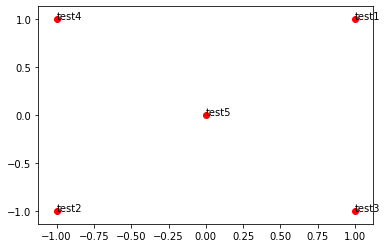

--------------------------------------------------------------------------------


In [19]:
# ---------------------
# Run this sanity check
# Note that this not an exhaustive check for correctness.
# The plot produced should look like the "test solution plot" depicted below. 
# ---------------------

print ("-" * 80)
print ("Outputted Plot:")

M_reduced_plot_test = np.array([[1, 1], [-1, -1], [1, -1], [-1, 1], [0, 0]])
word2Ind_plot_test = {'test1': 0, 'test2': 1, 'test3': 2, 'test4': 3, 'test5': 4}
words = ['test1', 'test2', 'test3', 'test4', 'test5']
plot_embeddings(M_reduced_plot_test, word2Ind_plot_test, words)

print ("-" * 80)

### Co-occurence Plot analysis

Now, using the above functions, we will compute the co-occurrence matrix with fixed window of 4, over the Reuters "crude" corpus. Then we will use TruncatedSVD to compute 2-dimensional embeddings of each word. TruncatedSVD returns U*S, so we normalize the returned vectors, so that all the vectors will appear around the unit circle (therefore closeness is directional closeness). ***Note:*** Below, normalization is performed using the NumPy concept of broadcasting. For more info on broadcasting, please refer - [Computation on Arrays: Broadcasting by Jake VanderPlas](https://jakevdp.github.io/PythonDataScienceHandbook/02.05-computation-on-arrays-broadcasting.html)

***Note:*** "bpd" stands for "barrels per day" and is commonly used abbreviation in crude oil topic articles

Done.
[[ 0.98750922 -0.15756123]
 [ 0.99184343 -0.12746216]
 [ 0.97435463  0.22501791]
 ...
 [ 0.95936322 -0.28217408]
 [ 0.98010885 -0.19846069]
 [ 0.99559602  0.09374733]]


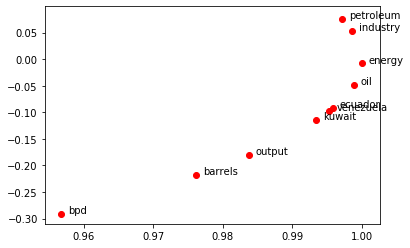

In [20]:
# -----------------------------
# Run This Cell to Produce the Plot
# ------------------------------
reuters_corpus = read_corpus()
M_co_occurrence, word2Ind_co_occurrence = compute_co_occurrence_matrix(reuters_corpus)
M_reduced_co_occurrence = reduce_to_k_dim(M_co_occurrence, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced_co_occurrence, axis=1)
M_normalized = M_reduced_co_occurrence / M_lengths[:, np.newaxis] # broadcasting

print(M_normalized)

words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']
plot_embeddings(M_normalized, word2Ind_co_occurrence, words)

### Prediction based word-vectors - word2Vec

More recently prediction-based word vectors have come into fashion, e.g. word2vec. Below, we will explore the embeddings produced by word2vec. Please refer [original paper](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)

In [21]:
def load_word2vec():
    """ Load Word2Vec Vectors
        Return:
            wv_from_bin: All 3 million embeddings, each lengh 300
    """
    import gensim.downloader as api
    wv_from_bin = api.load("word2vec-google-news-300")
    vocab = list(wv_from_bin.vocab.keys())
    print("Loaded vocab size %i" % len(vocab))
    return wv_from_bin

In [22]:
# -----------------------------------
# Run Cell to Load Word Vectors
# Note: This may take several minutes
# -----------------------------------
wv_from_bin = load_word2vec()

Loaded vocab size 3000000


### Reducing dimensionality of Word2Vec Word Embeddings

Now, we'll compare the word2vec embeddings to those of the co-occurrence matrix. Run the following cells to:

1. Put the 3 million word2vec vectors into a matrix M
2. Run reduce_to_k_dim (your Truncated SVD function) to reduce the vectors from 300-dimensional to 2-dimensional.

In [23]:
def get_matrix_of_vectors(wv_from_bin, required_words=['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']):
    """ Put the word2vec vectors into a matrix M.
        Param:
            wv_from_bin: KeyedVectors object; the 3 million word2vec vectors loaded from file
        Return:
            M: numpy matrix shape (num words, 300) containing the vectors
            word2Ind: dictionary mapping each word to its row number in M
    """
    import random
    words = list(wv_from_bin.vocab.keys())
    print("Shuffling words ...")
    random.shuffle(words)
    words = words[:10000]
    print("Putting %i words into word2Ind and matrix M..." % len(words))
    word2Ind = {}
    M = []
    curInd = 0
    for w in words:
        try:
            M.append(wv_from_bin.word_vec(w))
            word2Ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    for w in required_words:
        try:
            M.append(wv_from_bin.word_vec(w))
            word2Ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    M = np.stack(M)
    print("Done.")
    return M, word2Ind

In [24]:
# -----------------------------------------------------------------
# Run this Cell to Reduce 300-Dimensinal Word Embeddings to k Dimensions
# Note: This may take several minutes
# -----------------------------------------------------------------
M, word2Ind = get_matrix_of_vectors(wv_from_bin)
M_reduced = reduce_to_k_dim(M, k=2)

Shuffling words ...
Putting 10000 words into word2Ind and matrix M...
Done.
Done.


### word2vec plot analysis

Run the cell below to plot the 2D word2vec embeddings for ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela'].

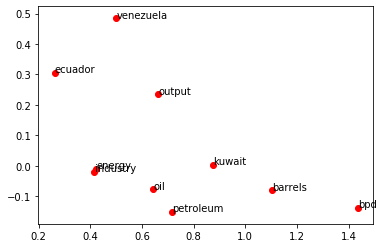

In [25]:
words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']
plot_embeddings(M_reduced, word2Ind, words)